# QUANTUM CIRCUIT FOR ISING MODEL SIMULATION

## Setup


Necessary libraries for the simulation:

In [6]:
# General
import numpy as np
import warnings

warnings.filterwarnings("ignore")

# Qiskit imports
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter
from qiskit.quantum_info import SparsePauliOp
import qiskit.quantum_info as qi

# Qiskit Runtime imports
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import EstimatorV2 as Estimator

# Plotting routines
import matplotlib.pyplot as plt
import matplotlib.ticker as tck

Log-in info for IBM:

In [7]:
from qiskit_ibm_runtime import QiskitRuntimeService

# Save an IBM Quantum account and set it as your default account.
#QiskitRuntimeService.save_account(channel="ibm_quantum", token="your IBM token here", set_as_default=True, overwrite = True)
 
# Load saved credentials
service = QiskitRuntimeService()

We check what machines are available:

In [8]:
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService(instance="ibm-q/open/main")
service.backends()
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(operational=True, simulator=False, min_num_qubits=4)
backend.name

'ibm_osaka'

We select the least busy machine to compute our circuit

## Previous (Classical numerical solution)

Here is diagonalization of the Ising Hamiltonian done with numpy (We will use it to compare the magnetitzation of the gs given by this method with the one we find with the quantum circuit)

In [9]:
#%% Necessary Vectors and Matrices

sigz = np.array([[1,0],[0,-1]])
sigx = np.array([[0,1],[1,0]])
ident2 = np.identity(2)
vec0 = np.array([[1],[0]])
vec1 = np.array([[0],[1]])

In [10]:
#%% Eigenvectors for sigz 

up4 = np.kron(vec0, np.kron(vec0, np.kron(vec0, vec0)))
up3down = np.kron(vec0, np.kron(vec0, np.kron(vec0, vec1)))
up2downup = np.kron(vec0, np.kron(vec0, np.kron(vec1, vec0)))
up2down2 = np.kron(vec0, np.kron(vec0, np.kron(vec1, vec1)))
updownup2 = np.kron(vec0, np.kron(vec1, np.kron(vec0, vec0)))
updowndupdown = np.kron(vec0, np.kron(vec1, np.kron(vec0, vec1)))
updown2up = np.kron(vec0, np.kron(vec1, np.kron(vec1, vec0)))
updown3 = np.kron(vec0, np.kron(vec1, np.kron(vec1, vec1)))
downup3 = np.kron(vec1, np.kron(vec0, np.kron(vec0, vec0)))
downup2down = np.kron(vec1, np.kron(vec0, np.kron(vec0, vec1)))
downupdownup = np.kron(vec1, np.kron(vec0, np.kron(vec1, vec0)))
downupdown2 = np.kron(vec1, np.kron(vec0, np.kron(vec1, vec1)))
down2up2 = np.kron(vec1, np.kron(vec1, np.kron(vec0, vec0)))
down2updown = np.kron(vec1, np.kron(vec1, np.kron(vec0, vec1)))
down3up = np.kron(vec1, np.kron(vec1, np.kron(vec1, vec0)))
down4 = np.kron(vec1, np.kron(vec1, np.kron(vec1, vec1)))

vecpar = np.array([up4,up2down2,updowndupdown,updown2up,downup2down,downupdownup,down2up2,down4])
vecsen = np.array([up3down,up2downup,updownup2,updown3,downup3,downupdown2,down2updown,down3up ])

#%% Projectors for even and odd parity states

Projecpar = np.zeros([16,16])
Projecsen = np.zeros([16,16])

for i in range(0,8):
    Projecpar += np.multiply(vecpar[i,::,::],np.transpose(vecpar[i,::,::]))
    Projecsen += np.multiply(vecsen[i,::,::],np.transpose(vecsen[i,::,::]))

Function that gives us the matrix for the Ising Hamiltonian

In [11]:
#%% Matrix for the Ising Hamiltonian
# N --> Number of lattices for the Ising Model
# l --> Strength of the magnetic field
# par --> Parity of the boundary conditions (Must be 1 or -1)

def HIsing(N, l, par):
    
    if par != -1 and par != 1:
        print('Not a valid parity for the boundary condition')
        sys.exit()
    
    #Our final Hamiltonian matrix
    Hising = np.zeros([2**N,2**N])
    
    #Necessary operators for all tensorial products
    #X term
    listmat = np.zeros([2,2,N])
    listmattemp = np.zeros([2,2,N])

    #Z term
    listmatz = np.zeros([2,2,N])
    listmattempz = np.zeros([2,2,N])

    for i in range(0, N):
        listmat[::,::,i] = np.identity(2)
        listmatz[::,::,i] = np.identity(2)
        
    #Tensorial products
    for j in range(0, N):
        
        listmattemp[::,::,::] = listmat[::,::,::]
        listmattempz[::,::,::] = listmatz[::,::,::]
        
        if j == (N-1):
            #X boundary term
            listmattemp[::,::,j] = sigx[::,::]
            listmattemp[::,::,0] = sigx[::,::]
            #Z term
            listmattempz[::,::,j] = sigz
            
        else:     
            #X term
            listmattemp[::,::,j] = sigx[::,::]
            listmattemp[::,::,j+1] = sigx[::,::]
            #Z term
            listmattempz[::,::,j] = sigz
        
        matinterx = listmattemp[::,::,0]
        matinterz = listmattempz[::,::,0]
        for k in range(0, N-1):
            if j == N-1:
                matdefx = par *np.kron(matinterx, listmattemp[::,::,k+1])
                matdefz = np.kron(matinterz, listmattempz[::,::,k+1])
                matinterx = matdefx
                matinterz = matdefz
            else:      
                matdefx = np.kron(matinterx, listmattemp[::,::,k+1])
                matdefz = np.kron(matinterz, listmattempz[::,::,k+1])
                matinterx = matdefx
                matinterz = matdefz
        #We sum the terms
        Hising += matdefx + l*matdefz
    
    return Hising

In [12]:
#%% Finite Hamiltonain Matrix
N = 4
eigenvalues = np.zeros((41,2**N))
eigenvectors = np.zeros((2**N,41, 2**N))

l = -2
for i in range(0,41, 1):
    Hpar = np.matmul(Projecpar, np.matmul(HIsing(N, l, -1), Projecpar))
    Hsen = np.matmul(Projecsen, np.matmul(HIsing(N, l, 1), Projecsen))
    Htot = Hpar + Hsen
    eigenvalues[i,::] = np.linalg.eigh(Htot)[0]
    eigenvectors[::,i,::] = np.linalg.eigh(Htot)[1]
    l += 0.1

In [13]:
teo1 = np.zeros((11))
teo2 = np.zeros((11))
teo3 = np.zeros((11))
teo4 = np.zeros((11))

for i in range(0, 11):
    if i != 10:
        #Magnetitzation diagonalizing the HIsing with python
        teo1[i] = np.abs(eigenvectors[0,i,0])**2
        teo2[i] = (2*(np.abs(eigenvectors[1,i+10,0])**2 + np.abs(eigenvectors[2,i+10,0])**2 + np.abs(eigenvectors[4,i+10,0])**2 + np.abs(eigenvectors[8,i+10,0])**2) - 2 * ((eigenvectors[7,i+10,0])**2 + np.abs(eigenvectors[11,i+10,0])**2 + np.abs(eigenvectors[13,i+10,0])**2 + np.abs(eigenvectors[14,i+10,0])**2))/4.
        teo3[i] = (2*(np.abs(eigenvectors[1,i+20,0])**2 + np.abs(eigenvectors[2,i+20,0])**2 + np.abs(eigenvectors[4,i+20,0])**2 + np.abs(eigenvectors[8,i+20,0])**2) - 2 * ((eigenvectors[7,i+20,0])**2 + np.abs(eigenvectors[11,i+20,0])**2 + np.abs(eigenvectors[13,i+20,0])**2 + np.abs(eigenvectors[14,i+20,0])**2))/4.
        teo4[i] = - np.abs(eigenvectors[15,i+30,0])**2
    else:
        teo1[i] = np.abs(eigenvectors[0,i,1])**2
        teo2[i] = (2*(np.abs(eigenvectors[1,i+10,1])**2 + np.abs(eigenvectors[2,i+10,1])**2 + np.abs(eigenvectors[4,i+10,1])**2 + np.abs(eigenvectors[8,i+10,1])**2) - 2 * ((eigenvectors[7,i+10,1])**2 + np.abs(eigenvectors[11,i+10,1])**2 + np.abs(eigenvectors[13,i+10,1])**2 + np.abs(eigenvectors[14,i+10,1])**2))/4.
        teo3[i] = (2*(np.abs(eigenvectors[1,i+20,1])**2 + np.abs(eigenvectors[2,i+20,1])**2 + np.abs(eigenvectors[4,i+20,1])**2 + np.abs(eigenvectors[8,i+20,1])**2) - 2 * ((eigenvectors[7,i+20,1])**2 + np.abs(eigenvectors[11,i+20,1])**2 + np.abs(eigenvectors[13,i+20,1])**2 + np.abs(eigenvectors[14,i+20,1])**2))/4.
        teo4[i] = - np.abs(eigenvectors[15,i+30,0])**2

## Gates Needed

### fSWAP Gate


In [9]:
# Gate for the 2qbit-Fourier Gate:
    # nq --> Number of qbits of our quantum circuit
    # q0 --> 
    # q1 --> 

def fSWAP(nq, q0, q1):
    circuit = QuantumCircuit(nq)
    circuit.swap(qreg_q[q0], qreg_q[q1])
    circuit.cz(qreg_q[q1], qreg_q[q0])
    return circuit 

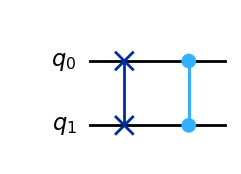

In [10]:
nq = 4
q0 = 1
q1 = 0

qreg_q = QuantumRegister(nq,'q')
creg_c = ClassicalRegister(nq,'c')
fSWAP_qc = fSWAP(nq,q0,q1)

fSWAPmat = qi.Operator(fSWAP(nq,q0,q1))
fSWAP_qc.draw(output="mpl", idle_wires=False, style="iqp")

### Fourier Gate

In [11]:
# Gate for the 2qbit-Fourier Gate:
    # nq --> Number of qbits of our quantum circuit
    # k --> Momentum
    # q0 --> 
    # q1 --> 
def fourier_2q(nq, k, q0, q1):
    circuit = QuantumCircuit(nq)
    phase = -(2.*np.pi*k)/(nq)
    circuit.p(phase,qreg_q[q0])
    circuit.cx(qreg_q[q0], qreg_q[q1])
    circuit.ch(qreg_q[q1], qreg_q[q0])
    circuit.cx(qreg_q[q0], qreg_q[q1])
    circuit.cz(qreg_q[q0], qreg_q[q1])
    return circuit

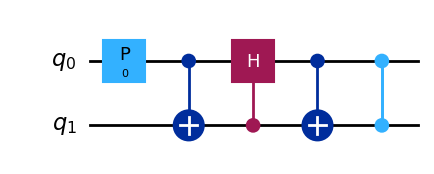

In [12]:
nq = 4
q0 = 0
q1 = 1
k = 0
qreg_q = QuantumRegister(nq,'q')
creg_c = ClassicalRegister(nq,'c')
F20_qc = fourier_2q(nq,k,q0,q1)
F20_qc.draw(output="mpl", idle_wires=False, style="iqp")

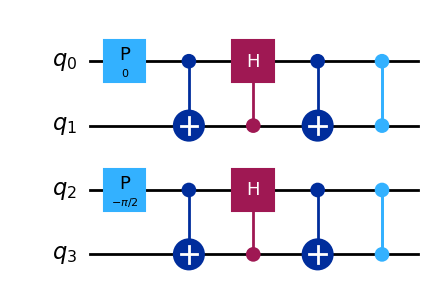

In [13]:
nq = 4
q0 = 2
q1 = 3
k = 1
qreg_q = QuantumRegister(nq,'q')
creg_c = ClassicalRegister(nq,'c')
F21_qc = fourier_2q(nq,k,q0,q1)
F21_qc.compose(F20_qc, inplace=True)
F21_qc.draw(output="mpl", idle_wires=False, style="iqp")

In [14]:
def fourier_2q_mat(N,nq, k, q0, q1):
    circuit = QuantumCircuit(nq)
    phase = -(2.*np.pi*k)/(N)
    circuit.p(phase,qreg_q[q0])
    circuit.cx(qreg_q[q0], qreg_q[q1])
    circuit.ch(qreg_q[q1], qreg_q[q0])
    circuit.cx(qreg_q[q0], qreg_q[q1])
    circuit.cz(qreg_q[q0], qreg_q[q1])
    return circuit

In [15]:
#
nq = 2
q0 = 0
q1 = 1
k = 0
qreg_q = QuantumRegister(nq, 'q')
creg_c = ClassicalRegister(nq, 'c')
F20mat_qc = fourier_2q_mat(4,nq,k,q0,q1)
F20_mat = np.round(qi.Operator(F20mat_qc), 10)
print(F20_mat)

[[ 1.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j]
 [ 0.        +0.j -0.70710678+0.j  0.70710678+0.j  0.        +0.j]
 [ 0.        +0.j  0.70710678+0.j  0.70710678+0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j  0.        +0.j -1.        +0.j]]


### Bogoulibov Gate

In [16]:
# Gate for the 2qbit-Bogoulibov Gate:
    # nq --> Number of qbits of our quantum circuit
    # k --> Momentum
    # q0 --> 
    # q1 --> 
    # lamb --> Strength of the magnetic field
def bogo_2q(nq, k, q0, q1, lamb):
    kn = (2*np.pi*k)/(nq)   
    if lamb == 1 and k == 0:
        thetak = 0
    else:
        thetak = np.arctan(np.sin(kn)/(np.cos(kn)-lamb))
    circuit = QuantumCircuit(nq)
    circuit.x(qreg_q[q1])
    circuit.cx(qreg_q[q1], qreg_q[q0])
    circuit.crx(-thetak,qreg_q[q0], qreg_q[q1])
    circuit.cx(qreg_q[q1], qreg_q[q0])
    circuit.x(qreg_q[q1])
    return circuit

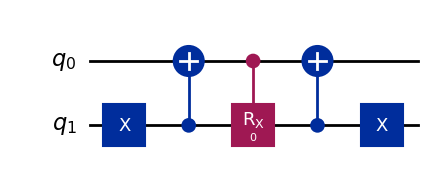

In [17]:
#
nq = 4
q0 = 0
q1 = 1
k = 0
lamb = 1
qreg_q = QuantumRegister(nq, 'q')
creg_c = ClassicalRegister(nq, 'c')
B20_qc = bogo_2q(nq,k,q0,q1,lamb)
B20_qc.draw(output="mpl", idle_wires=False, style="iqp")

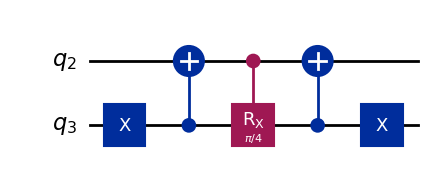

In [18]:
#
nq = 4
q0 = 2
q1 = 3
k = 1
lamb = 1
qreg_q = QuantumRegister(nq, 'q')
creg_c = ClassicalRegister(nq, 'c')
B21_qc = bogo_2q(nq,k,q0,q1,lamb)
B21_qc = bogo_2q(nq,k,q0,q1,lamb)
B21_qc.draw(output="mpl", idle_wires=False, style="iqp")

In [19]:
# Gate for the 2qbit-Bogoulibov Gate:
    # nq --> Number of qbits of our quantum circuit
    # k --> Momentum
    # q0 --> 
    # q1 --> 
    # lam --> Strength of the magnetic field
def bogo_2q_mat(N,nq, k, q0, q1,lamb):
    kn = (2*np.pi*k)/(N)
    if lamb == 1:
        if k != 0:
            thetak = -np.pi/2.
        if k == 0:
            thetak = 0
    else:
        thetak = np.arctan(np.sin(kn)/(np.cos(kn)-lamb))
    circuit = QuantumCircuit(nq)
    circuit.x(qreg_q[q1])
    circuit.cx(qreg_q[q1], qreg_q[q0])
    circuit.crx(-thetak,qreg_q[q0], qreg_q[q1])
    circuit.cx(qreg_q[q1], qreg_q[q0])
    circuit.x(qreg_q[q1])
    return circuit

In [20]:
#
nq = 2
q0 = 0
q1 = 1
k = 0
lamb = 1
qreg_q = QuantumRegister(nq, 'q')
creg_c = ClassicalRegister(nq, 'c')
B20mat_qc = bogo_2q_mat(4,nq,k,q0,q1,lamb)
B20_mat = np.round(qi.Operator(B20mat_qc), 10)
print(B20_mat)

[[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j]]


In [21]:
#
nq = 2
q0 = 0
q1 = 1
k = 1
lamb = -1.
qreg_q = QuantumRegister(nq, 'q')
creg_c = ClassicalRegister(nq, 'c')
B21mat_qc = bogo_2q_mat(4,nq,k,q0,q1,lamb)
B21_mat = np.round(qi.Operator(B21mat_qc), 10)
print(B21_mat)

[[0.92387953+0.j         0.        +0.j         0.        +0.j
  0.        +0.38268343j]
 [0.        +0.j         1.        +0.j         0.        +0.j
  0.        +0.j        ]
 [0.        +0.j         0.        +0.j         1.        +0.j
  0.        +0.j        ]
 [0.        +0.38268343j 0.        +0.j         0.        +0.j
  0.92387953+0.j        ]]


## Quantum circuit trial

### Quantum Circuit for diagonalizing the Ising Hamiltonian

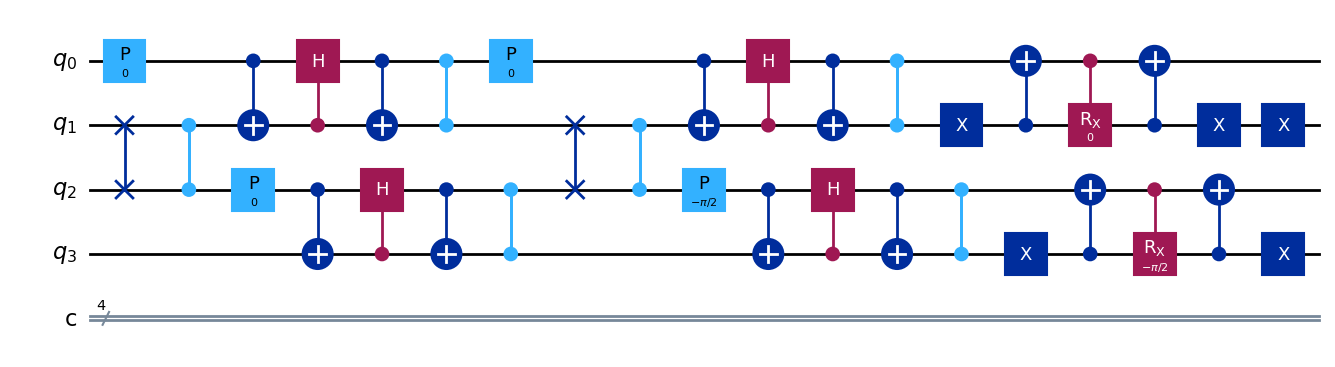

In [22]:
nq = 4
q0 = 0
q1 = 1
q2 = 2
q3 = 3
k0 = 0
k1 = 1
lamb = 0

qreg_q = QuantumRegister(nq, 'q')
creg_c = ClassicalRegister(nq, 'c')
ising_qc = QuantumCircuit(qreg_q, creg_c)

ising_qc.compose(fSWAP(nq,q1,q2), inplace=True)
ising_qc.compose(fourier_2q(nq,k0,q0,q1), inplace=True)
ising_qc.compose(fourier_2q(nq,k0,q2,q3), inplace=True)
ising_qc.compose(fSWAP(nq,q1,q2), inplace=True)
ising_qc.compose(fourier_2q(nq,k0,q0,q1), qubits = [0,1,2,3], inplace=True)
ising_qc.compose(fourier_2q(nq,k1,q2,q3), qubits = [0,1,2,3], inplace=True)
ising_qc.compose(bogo_2q(nq,k0,q0,q1,lamb), inplace=True)
ising_qc.compose(bogo_2q(nq,k1,q2,q3,lamb), inplace=True)
ising_qc.x(qreg_q[q1])

ising_qc.draw(output="mpl", idle_wires=True, style="iqp")

In [16]:
from qiskit.providers.fake_provider import GenericBackendV2
 
# Generate a 5-qubit simulated backend
backend = GenericBackendV2(num_qubits=5)

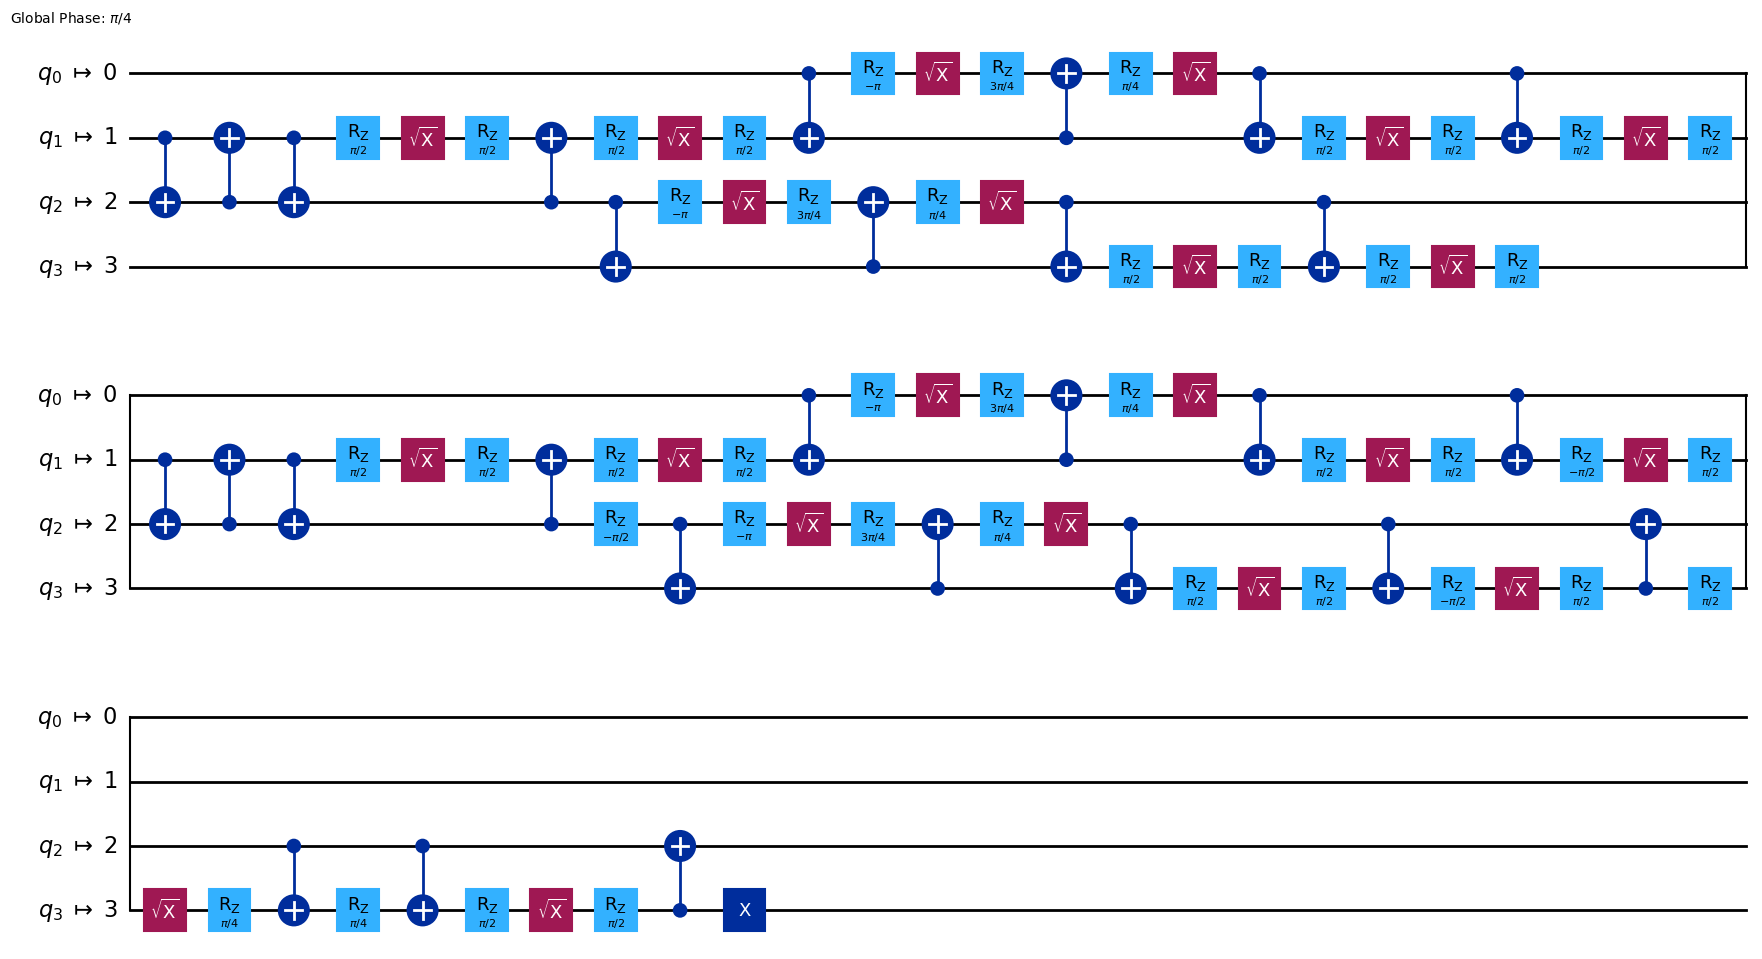

In [24]:
#Transpile the circuit for the backend used
ising_qc_trans = transpile(ising_qc, backend)
ising_qc_trans.draw(output="mpl", idle_wires=False, style="iqp")

### Inverse Quantum Circuit for diagonalizing the Ising Hamiltonian

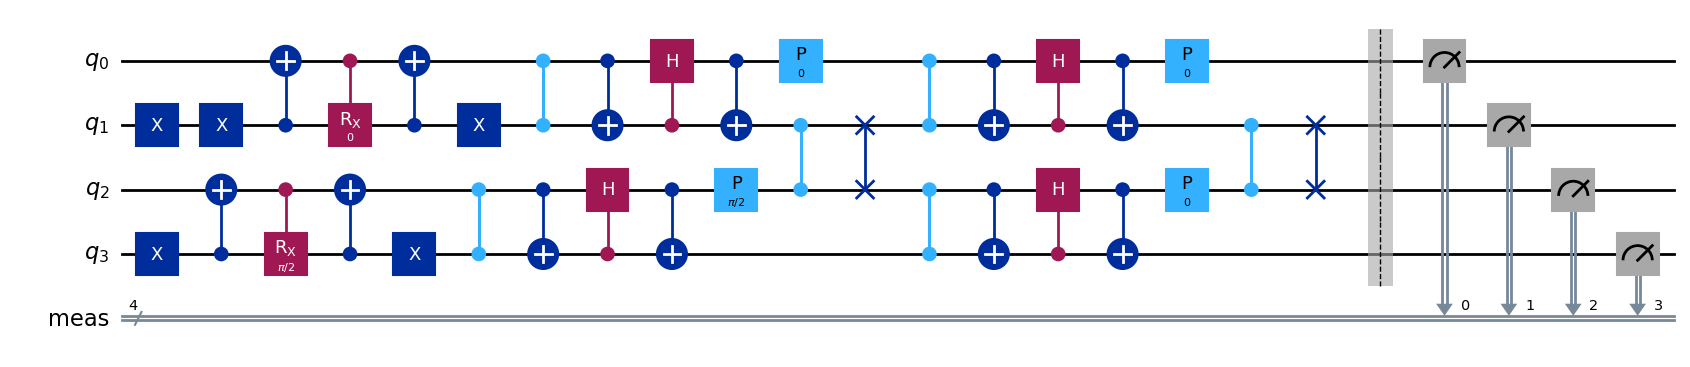

In [25]:
ising_qc_inv = ising_qc.inverse()
ising_qc_inv.measure_all()
ising_qc_inv.draw(output="mpl", idle_wires=False, style="iqp")

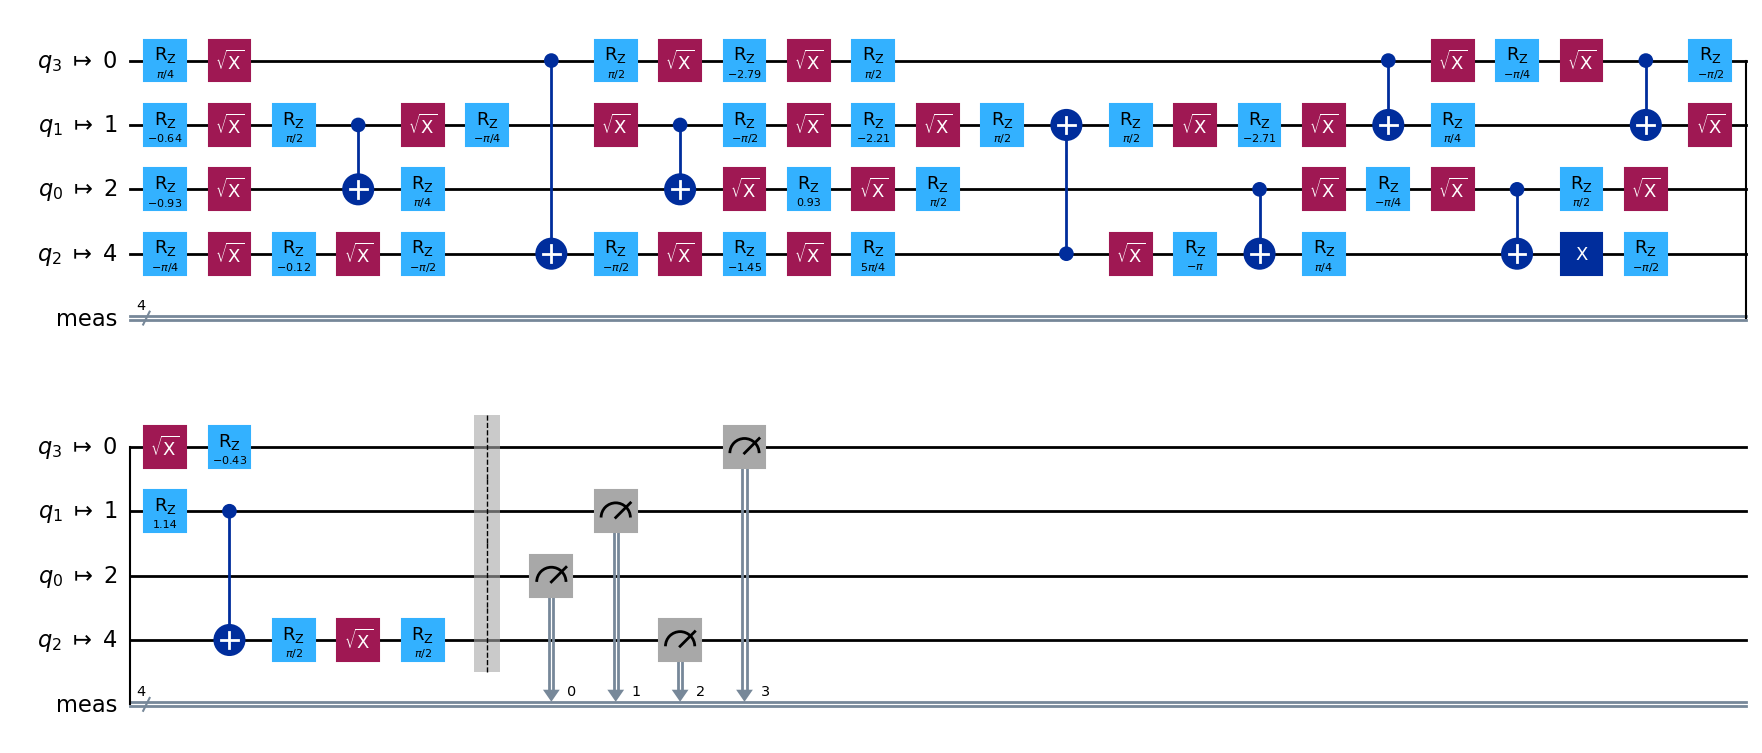

In [26]:
#Transpile the circuit for the backend used
ising_qc_inv_trans = transpile(ising_qc_inv, backend, optimization_level = 3)
ising_qc_inv_trans.draw(output="mpl", idle_wires=False, style="iqp")

## Results

Necessary dictionary to get the magnetitzation after the measurement:

In [27]:
dictmag = thisdict = {'0000 0000': 4 ,'0001 0000': 2,'0010 0000': 2,'0011 0000': 0,
                      '0100 0000': 2,'0101 0000': 0,'0110 0000': 0,'0111 0000': -2,
                      '1000 0000': 2,'1001 0000': 0,'1010 0000': 0,'1011 0000': -2,
                      '1100 0000': 0,'1101 0000': -2,'1110 0000': -2,'1111 0000': -4}

### Simulator results

#### Simulator selection

Here we chose to use a simulator **(if we want to use real quantum hardware skip this cell!!)**

In [17]:
# Generate a 4-qubit simulated backend
backend_sim = GenericBackendV2(num_qubits=4)

#### QC with Simulator

In [54]:
#Number of qubits
nq = 4
q0 = 0
q1 = 1
q2 = 2
q3 = 3

#Momentums
k0 = 0
k1 = 1

#Values for lamb
lamb = np.linspace(-1.95,1.95, 15)

#Number of measures
Nshots = 500
#Variables Where we will store our results
Mag_sim = np.zeros(15)
desv_sim = np.zeros(15)
Err_sim = np.zeros(15)

maxcreds = 2

for i in range(0, 15):
    qreg_q = QuantumRegister(nq, 'q')
    creg_c = ClassicalRegister(nq, 'c')
    ising_qc = QuantumCircuit(qreg_q, creg_c)

    #Quantum circuit
    ising_qc.compose(fSWAP(nq,q1,q2), inplace=True)
    ising_qc.compose(fourier_2q(nq,k0,q0,q1), inplace=True)
    ising_qc.compose(fourier_2q(nq,k0,q2,q3), inplace=True)
    ising_qc.compose(fSWAP(nq,q1,q2), inplace=True)
    ising_qc.compose(fourier_2q(nq,k0,q0,q1), qubits = [0,1,2,3], inplace=True)
    ising_qc.compose(fourier_2q(nq,k1,q2,q3), qubits = [0,1,2,3], inplace=True)
    ising_qc.compose(bogo_2q(nq,k1,q2,q3,lamb[i]), inplace=True)

    #We select the correct inital vector
    if lamb[i] >= -1 and lamb[i] < 0:
        ising_qc.x(qreg_q[q1])
    elif lamb[i] >= 0 and lamb[i] < 1:
        ising_qc.x(qreg_q[q1])
        ising_qc.x(qreg_q[q2])
        ising_qc.x(qreg_q[q3])
    elif lamb[i] >= 1:
        ising_qc.x(qreg_q[q0])
        ising_qc.x(qreg_q[q1])
        ising_qc.x(qreg_q[q2])
        ising_qc.x(qreg_q[q3])   
        
    #Invert the quantum circuit
    ising_qc_inv = ising_qc.inverse()
    ising_qc_inv.measure_all()
    
    #Transpile
    ising_qc_inv_trans = transpile(ising_qc_inv,backend_sim,optimization_level=3)
    
    #We run the circuit
    job = backend_sim.run(ising_qc_inv_trans, shots = Nshots)

    # Retrieve and analyze the results
    result = job.result()
    counts = result.get_counts(ising_qc_inv_trans)
    print(i, lamb[i], "Measurement results:", counts)
    keys_counts = list(counts.keys())
    for j in range(0, len(keys_counts)):
        Mag_sim[i] += counts[keys_counts[j]] * dictmag[keys_counts[j]]/4
    Mag_sim[i] = Mag_sim[i]/Nshots
    
    # Errors
    for j in range(0, len(keys_counts)):
        desv_sim[i] += counts[keys_counts[j]] * (Mag_sim[i] - (dictmag[keys_counts[j]]/4))**2
    Err_sim[i] = np.sqrt(desv_sim[i] /Nshots)/np.sqrt(Nshots)

0 -1.95 Measurement results: {'0000 0000': 469, '0110 0000': 13, '1001 0000': 8, '1100 0000': 5, '0011 0000': 5}
1 -1.6714285714285713 Measurement results: {'0000 0000': 474, '1001 0000': 6, '0011 0000': 10, '0110 0000': 5, '1100 0000': 5}
2 -1.3928571428571428 Measurement results: {'1100 0000': 13, '0000 0000': 441, '0011 0000': 15, '1001 0000': 17, '0110 0000': 14}
3 -1.1142857142857143 Measurement results: {'0000 0000': 442, '0110 0000': 10, '0011 0000': 18, '1001 0000': 22, '1100 0000': 8}
4 -0.8357142857142856 Measurement results: {'0100 0000': 90, '0010 0000': 108, '0111 0000': 22, '1000 0000': 110, '0001 0000': 100, '1011 0000': 23, '1110 0000': 23, '1101 0000': 24}
5 -0.5571428571428572 Measurement results: {'0100 0000': 99, '0001 0000': 99, '0111 0000': 30, '1000 0000': 107, '0010 0000': 78, '1101 0000': 40, '1110 0000': 23, '1011 0000': 24}
6 -0.27857142857142847 Measurement results: {'1101 0000': 45, '0001 0000': 92, '1000 0000': 78, '0100 0000': 73, '1110 0000': 48, '1011 0

In [56]:
print(Err_sim)

[0.0107848  0.00992935 0.01442747 0.01432089 0.01732882 0.01893378
 0.02133073 0.02235424 0.02115448 0.01971314 0.01732882 0.01523443
 0.01353484 0.01125842 0.01028241]


In [57]:
print(Mag_sim)

[ 0.938  0.948  0.882  0.884  0.316  0.266  0.15  -0.012 -0.162 -0.236
 -0.316 -0.866 -0.898 -0.932 -0.944]


### Machine results

#### Machine selection

We check what machines are available:

In [18]:
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService(instance="ibm-q/open/main")
service.backends()

[<IBMBackend('ibm_kyoto')>,
 <IBMBackend('ibm_osaka')>,
 <IBMBackend('ibm_sherbrooke')>,
 <IBMBackend('ibm_brisbane')>]

In [19]:
service = QiskitRuntimeService(channel="ibm_quantum")
backend_mac = service.least_busy(operational=True, simulator=False, min_num_qubits=4)
backend_mac.name

'ibm_osaka'

#### QC with Machine

In [39]:
#Number of qubits
nq = 4
q0 = 0
q1 = 1
q2 = 2
q3 = 3

#Momentums
k0 = 0
k1 = 1

#Values for lamb
lamb = np.linspace(-1.95,1.95, 15)

#Number of measures
Nshots = 500

#Variables where we will store our results
Mag_mac = np.zeros(15)
desv_mac = np.zeros(15)
Err_mac = np.zeros(15)

maxcreds = 2

for i in range(0, 15):
    qreg_q = QuantumRegister(nq, 'q')
    creg_c = ClassicalRegister(nq, 'c')
    ising_qc = QuantumCircuit(qreg_q, creg_c)

    #Quantum circuit
    ising_qc.compose(fSWAP(nq,q1,q2), inplace=True)
    ising_qc.compose(fourier_2q(nq,k0,q0,q1), inplace=True)
    ising_qc.compose(fourier_2q(nq,k0,q2,q3), inplace=True)
    ising_qc.compose(fSWAP(nq,q1,q2), inplace=True)
    ising_qc.compose(fourier_2q(nq,k0,q0,q1), qubits = [0,1,2,3], inplace=True)
    ising_qc.compose(fourier_2q(nq,k1,q2,q3), qubits = [0,1,2,3], inplace=True)
    ising_qc.compose(bogo_2q(nq,k1,q2,q3,lamb[i]), inplace=True)
    
    #We select the correct inital vector
    if lamb[i] >= -1 and lamb[i] < 0:
        ising_qc.x(qreg_q[q1])
    elif lamb[i] >= 0 and lamb[i] < 1:
        ising_qc.x(qreg_q[q1])
        ising_qc.x(qreg_q[q2])
        ising_qc.x(qreg_q[q3])
    elif lamb[i] >= 1:
        ising_qc.x(qreg_q[q0])
        ising_qc.x(qreg_q[q1])
        ising_qc.x(qreg_q[q2])
        ising_qc.x(qreg_q[q3])   
        
    #Invert the quantum circuit
    ising_qc_inv = ising_qc.inverse()
    ising_qc_inv.measure_all()
    
    #Transpile
    ising_qc_inv_trans = transpile(ising_qc_inv, backend_mac,optimization_level=3)
    ising_qc_inv_trans.draw(output="mpl", idle_wires=False, style="iqp")
    
    #We run the circuit
    job = backend_mac.run(ising_qc_inv_trans, shots = Nshots, max_credits=maxcreds)

    # Retrieve and analyze the results
    result = job.result()
    counts = result.get_counts(ising_qc_inv_trans)
    print(i, "Measurement results:", counts)
    keys_counts = list(counts.keys())
    for j in range(0, len(keys_counts)):
        Mag_mac[i] += counts[keys_counts[j]] * dictmag[keys_counts[j]]/4
    Mag_mac[i] = Mag_mac[i]/Nshots
    
    # Errors
    for j in range(0, len(keys_counts)):
        desv_mac[i] += counts[keys_counts[j]] * (Mag_mac[i] - (dictmag[keys_counts[j]]/4))**2
    Err_mac[i] = np.sqrt(desv_mac[i] /Nshots)/np.sqrt(Nshots)

0 Measurement results: {'1001 0000': 9, '0001 0000': 43, '1111 0000': 1, '1101 0000': 1, '0011 0000': 15, '0110 0000': 11, '1110 0000': 1, '0101 0000': 4, '0111 0000': 1, '1010 0000': 4, '0100 0000': 18, '1000 0000': 12, '0000 0000': 355, '1100 0000': 10, '0010 0000': 15}
1 Measurement results: {'1011 0000': 1, '0110 0000': 4, '0010 0000': 25, '0011 0000': 6, '1101 0000': 3, '0001 0000': 11, '1010 0000': 2, '0101 0000': 2, '0100 0000': 32, '0111 0000': 1, '1001 0000': 10, '1000 0000': 17, '1100 0000': 11, '0000 0000': 375}
2 Measurement results: {'0101 0000': 4, '0010 0000': 11, '1100 0000': 8, '1001 0000': 18, '0111 0000': 3, '1000 0000': 21, '0110 0000': 6, '1011 0000': 2, '1010 0000': 3, '0100 0000': 33, '0001 0000': 53, '0000 0000': 323, '1101 0000': 6, '0011 0000': 9}
3 Measurement results: {'0011 0000': 8, '1010 0000': 9, '1100 0000': 19, '0110 0000': 9, '1101 0000': 1, '1001 0000': 13, '0001 0000': 15, '0000 0000': 381, '0010 0000': 13, '1011 0000': 1, '1000 0000': 12, '0100 000

In [40]:
print(Err_mac)

[0.01604064 0.01456709 0.01694054 0.01582049 0.01776941 0.0199912
 0.0226855  0.02204468 0.02182929 0.01932102 0.01778196 0.01646718
 0.01668167 0.0155386  0.01655899]


In [41]:
print(Mag_mac)

[ 0.793  0.83   0.753  0.816  0.318  0.224  0.178  0.004 -0.079 -0.207
 -0.299 -0.804 -0.769 -0.826 -0.77 ]


In [4]:
Err_mac = np.array([0.01604064, 0.01456709, 0.01694054, 0.01582049, 0.01776941, 0.0199912,
 0.0226855,  0.02204468, 0.02182929, 0.01932102, 0.01778196, 0.01646718,
 0.01668167, 0.0155386,  0.01655899])

Mag_mac = np.array([ 0.793,  0.83,   0.753,  0.816,  0.318,  0.224,  0.178,  0.004, -0.079, -0.207,
 -0.299, -0.804, -0.769, -0.826, -0.77 ])

Err_sim = np.array([0.0107848,  0.00992935, 0.01442747, 0.01432089, 0.01732882, 0.01893378,
 0.02133073, 0.02235424, 0.02115448, 0.01971314, 0.01732882, 0.01523443,
 0.01353484, 0.01125842, 0.01028241])

Mag_sim = np.array([ 0.938,  0.948,  0.882,  0.884,  0.316,  0.266,  0.15,  -0.012, -0.162, -0.236,
 -0.316, -0.866, -0.898, -0.932, -0.944])

# Post-Processing

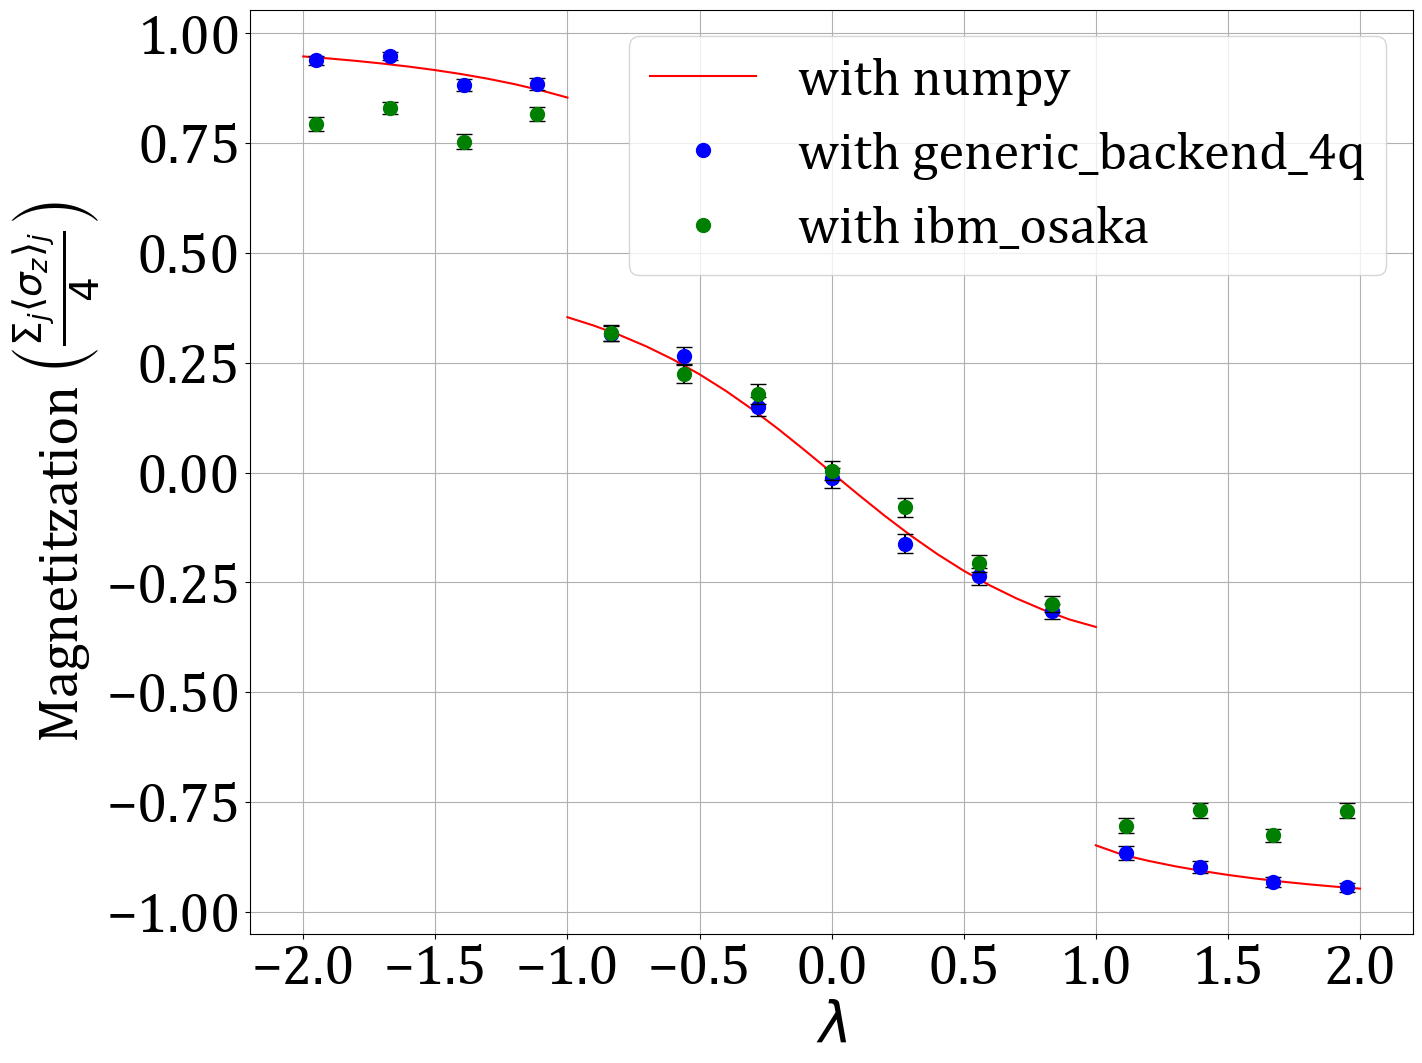

In [33]:
import matplotlib.font_manager as font_manager

plt.figure(figsize = [15,12])
plt.grid(True)
plt.ylabel(r'Magnetitzation $\left(\frac{\Sigma_{j}\langle\sigma_{z}\rangle_{j}}{4}\right)$', fontsize = 40, fontname="Cambria")
plt.xlabel(r'$\lambda$', fontsize = 40, fontname="Cambria") 
plt.xticks(fontsize = 40, fontname="Cambria")
plt.yticks(fontsize = 40, fontname="Cambria")

#Theoretical value
xteo = np.linspace(-2, 2, 41)
plt.plot(xteo[0:11], teo1, color = 'red')
plt.plot(xteo[10:21], teo2, color = 'red')
plt.plot(xteo[20:31], teo3, color = 'red')
plt.plot(xteo[30:41], teo4, color = 'red', label='with numpy')

#Experimental values
xexp = np.linspace(-1.95, 1.95, 15)
## Simulator
plt.errorbar(xexp, Mag_sim, yerr = Err_sim, fmt = 'None', color = 'black', capsize = 6)
plt.plot(xexp, Mag_sim, linestyle = 'none',color = 'blue', label= f'with {backend_sim.name}', marker='o', markersize=10)

## Machine
plt.errorbar(xexp, Mag_mac, yerr = Err_mac, fmt = 'None', color = 'black', capsize = 6)
plt.plot(xexp, Mag_mac, linestyle = 'none',color = 'green', label=f'with {backend_mac.name}', marker='o', markersize=10)

font = font_manager.FontProperties(family='Cambria',
                                   style='normal', size=38)

#Save the fig
plt.legend(prop=font)
plt.savefig('magnetitzation2.png')

In [60]:
import qiskit_ibm_runtime

qiskit_ibm_runtime.version.get_version_info()

'0.23.0'

In [61]:
import qiskit

qiskit.version.get_version_info()

'1.1.0'